In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from src.load_data import load_data

save_path = "/Users/ppopov1/adm-proj/data/pyspi_proc/"
families = ["cov_", "cov-sq_", "prec_"]

fbirn_data, demographics = load_data()
timeseries = fbirn_data["data"]
diagnoses = fbirn_data["diags"]
sexes = fbirn_data["sexes"]
ages = fbirn_data["ages"]

print(demographics)
print(f"# subjects: {timeseries.shape[0]}, # timepoints: {timeseries.shape[1]}, # features: {timeseries.shape[2]}")

     Category          Statistic/Label   Value
0   Diagnosis             Count HC (0)  160.00
1   Diagnosis             Count SZ (1)  151.00
2         Sex           Count Male (0)  230.00
3         Sex         Count Female (1)   81.00
4         Age                      Min   18.00
5         Age                      Max   62.00
6         Age                     Mean   37.88
7         Age                  Std Dev   11.24
8    Age Bins  Count Bin 0 (18.0-32.7)  119.00
9    Age Bins  Count Bin 1 (32.7-47.3)  117.00
10   Age Bins  Count Bin 2 (47.3-62.0)   75.00
# subjects: 311, # timepoints: 140, # features: 53


In [12]:
ica_coords = pd.read_csv("data/ICN_coordinates.csv")
domains = ica_coords["Domain"]
# update nans with previous value
domains = domains.fillna(method='ffill')
domains = np.asarray(domains.tolist())

change_idx = np.flatnonzero(np.r_[True, domains[1:] != domains[:-1]])
# change_idx marks the start index of each group
starts = change_idx
# compute ends (inclusive) indices for each group
ends = np.r_[starts[1:] - 1, domains.size - 1]
centers = ((starts + ends) / 2.0).tolist()
# boundaries are positions between pixels: (end + 0.4) for each group except last
boundaries = (ends[:-1] + 0.4).tolist()

group_names_full = [domains[s] for s in starts]
group_names = ["SC", "AU", "SM", "VIS", "CC", "DM", "CB"]  # short names

/var/folders/c7/h35llrbd2h76sn_0f75rjyz00000gq/T/ipykernel_43671/2963762152.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  domains = domains.fillna(method='ffill')


In [13]:
# load the data
import dill
with open(save_path+"good_data.pkl", 'rb') as f:
    DATA = dill.load(f) 
with open(save_path+"stats.pkl", 'rb') as f:
    STATS = dill.load(f)
with open(save_path+"proc_stats.pkl", 'rb') as f:
    PROC_STATS = dill.load(f)

In [14]:
def ttest(data0, data1):
    stat, p_value = stats.ttest_ind(data0, data1, axis=0, equal_var=False)
    return stat, p_value

def analyze_group_differences(data, labels, stat_func = ttest, fdr=True, p_threshold=0.05):
    groups = np.unique(labels)

    C = data.shape[1]
    tril_indices = np.tril_indices(data.shape[1], k=-1)
    X = data[:, tril_indices[0], tril_indices[1]]
    n_samples = X.shape[0]
    X = X.reshape(n_samples, -1)

    group_data = [X[labels == g] for g in groups]

    stat, p_value = stat_func(group_data[0], group_data[1])
    if fdr:
        p_threshold = p_threshold/p_value.shape[0]
    p_thresh = (p_value < p_threshold).astype(int)

    # reshape importances back to matrix form
    full_stat, full_p_value, full_p_thresh = np.zeros((C, C)), np.zeros((C, C)), np.zeros((C, C))
    full_stat[tril_indices], full_p_value[tril_indices], full_p_thresh[tril_indices] = stat, p_value, p_thresh
    full_stat, full_p_value, full_p_thresh = full_stat + full_stat.T, full_p_value + full_p_value.T, full_p_thresh + full_p_thresh.T
    stat, p_value, p_thresh = full_stat, full_p_value, full_p_thresh

    # #######
    # group_data = [data[labels == g] for g in groups]

    # stat, p_value = stat_func(group_data[0], group_data[1])
    # if fdr:
    #     print(data.shape[1]*data.shape[2])
    #     p_threshold = p_threshold/data.shape[1]
    # p_thresh = (p_value < p_threshold).astype(int)
    # #######

    return stat, p_value, p_thresh.astype(bool)

def plot_heatmap(matrix, ax, cmap='bwr', vmin=None, vmax=None, guides_color='k'):
    cax = ax.imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks(centers)
    ax.set_xticklabels(group_names)
    ax.set_yticks(centers)
    ax.set_yticklabels(group_names)
    for boundary in boundaries:
        ax.axhline(boundary, color=guides_color, linewidth=1.5)
        ax.axvline(boundary, color=guides_color, linewidth=1.5)
    return cax

def plot_stats(stat, p_vals, p_thresh, title=""):
    fig, ax = plt.subplots(1, 3, figsize=(14, 5))
    cax1 = plot_heatmap(stat, ax[0], vmin=-5, vmax=5)
    ax[0].set_title("T-statistics" if title == "" else f"T-statistics ({title})")
    fig.colorbar(cax1, ax=ax[0], fraction=0.045)  

    cax2 = plot_heatmap(p_vals, ax[1], vmin=0, vmax=1, cmap='inferno_r')
    ax[1].set_title("p-values")
    fig.colorbar(cax2, ax=ax[1], fraction=0.045)  

    cax3 = plot_heatmap(p_thresh, ax[2], vmin=0, vmax=1, cmap='inferno', guides_color='white')
    ax[2].set_title("Significant p-values")
    cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
    cbar3.set_ticks([0, 1])
    cbar3.set_ticklabels(['False', 'True'])

    plt.tight_layout()
    plt.show()

def plot_means(data, labels, title="", unit_lim=True):
    groups = np.unique(labels)
    group_data = [data[diagnoses == g] for g in groups]
    means = [np.mean(gd, axis=0) for gd in group_data]

    if unit_lim:
        vmin, vmax = -1, 1
    else:
        vmax = max([np.max(np.abs(m)) for m in means])
        vmin = -vmax
        
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    cax = plot_heatmap(means[0], ax[0], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[0], fraction=0.045)
    ax[0].set_title(f"Patients Mean {title}")
    cax = plot_heatmap(means[1], ax[1], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[1], fraction=0.045)
    ax[1].set_title(f"Controls Mean {title}")
    plt.tight_layout()
    plt.show()

# pictures

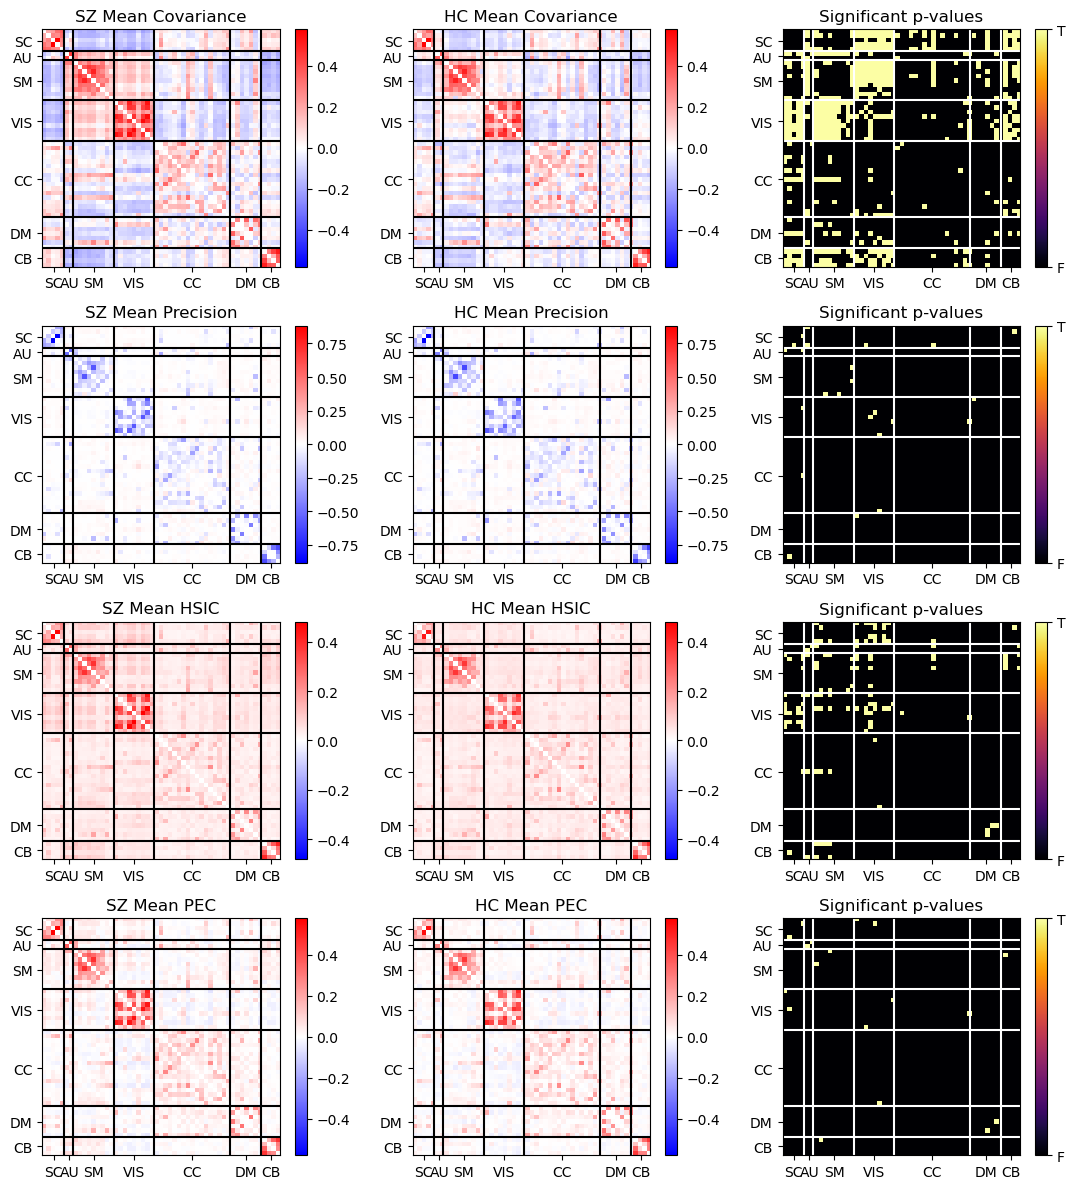

In [39]:
spis_to_plot = ['cov_GraphicalLassoCV', 'prec_GraphicalLassoCV', 'hsic', 'pec']
spis_titles = ['Covariance', 'Precision', 'HSIC', 'PEC']

unit_lim = False
fig, axes = plt.subplots(len(spis_to_plot), 3, figsize=(11, 3*len(spis_to_plot)))
for i, (spi, spi_title) in enumerate(zip(spis_to_plot, spis_titles)):
    ax = axes[i]
    data = DATA[spi]
    labels = DATA["diags"]
    groups = np.unique(labels)
    group_data = [data[labels == g] for g in groups]
    means = [np.mean(gd, axis=0) for gd in group_data]

    if unit_lim:
        vmin, vmax = -1, 1
    else:
        # print(means[0])
        vmax = max([np.nanmax(np.abs(m)) for m in means])
        vmin = -vmax
        
    cax = plot_heatmap(means[0], ax[0], cmap='bwr', vmin=vmin, vmax=vmax)
    # fig.colorbar(cax, ax=ax[0], fraction=0.045)
    fig.colorbar(cax, ax=ax[0], fraction=0.045)
    ax[0].set_title(f"SZ Mean {spi_title}")
    cax = plot_heatmap(means[1], ax[1], cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(cax, ax=ax[1], fraction=0.045)
    ax[1].set_title(f"HC Mean {spi_title}")
    # plot_heatmap(means[0], ax[0], cmap='bwr', vmin=vmin, vmax=vmax)
    # ax[0].set_title(f"SZ Mean {spi_title}")
    # plot_heatmap(means[1], ax[1], cmap='bwr', vmin=vmin, vmax=vmax)
    # ax[1].set_title(f"HC Mean {spi_title}")


    stat = STATS[spi]["stat"]
    p_value = STATS[spi]["p_value"]
    p_thresh = STATS[spi]["p_thresh"]

    cax3 = plot_heatmap(p_thresh, ax[2], vmin=0, vmax=1, cmap='inferno', guides_color='white')
    ax[2].set_title(f"Significant p-values")
    cbar3 = fig.colorbar(cax3, ax=ax[2], fraction=0.045)
    cbar3.set_ticks([0, 1])
    cbar3.set_ticklabels(['F', 'T'])

plt.tight_layout()
plt.show()